# CNN Post-Training Quantization Demo

This notebook demonstrates quantizing a CNN trained on CIFAR-10 from 32-bit floating point to 8-bit integers.

In [60]:
# CNN Post-Training Quantization Demo
import os
import sys
from pathlib import Path
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Setup paths and imports
project_root = str(Path(os.getcwd()).parent.absolute())
if project_root not in sys.path:
    sys.path.append(project_root)
    
from src.model.cnn import Net
from src.model.quantized_cnn import QuantizedNet
from src.quantization.weight_quant import quantize_layer_weights
from src.quantization.act_quant import register_activation_profiling_hooks
from src.quantization.bias_quant import quantize_model_biases
from src.train import train_model, test_model
from src.utils.visualization import plot_weight_distribution, plot_activation_distribution

# Load and prepare data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                       shuffle=False, num_workers=2)

# Initialize and train base model
net = Net().to(device)

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


Visualizing Initial Weights


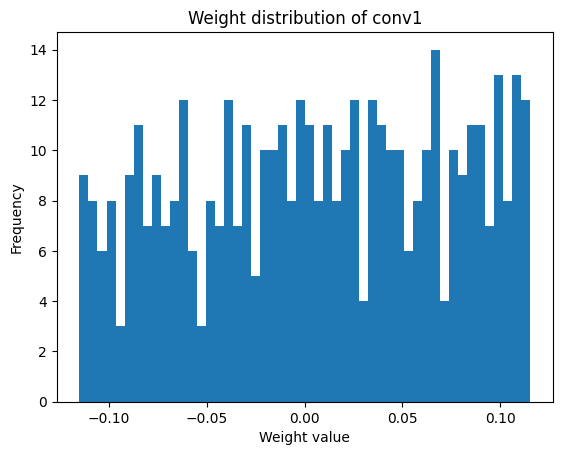

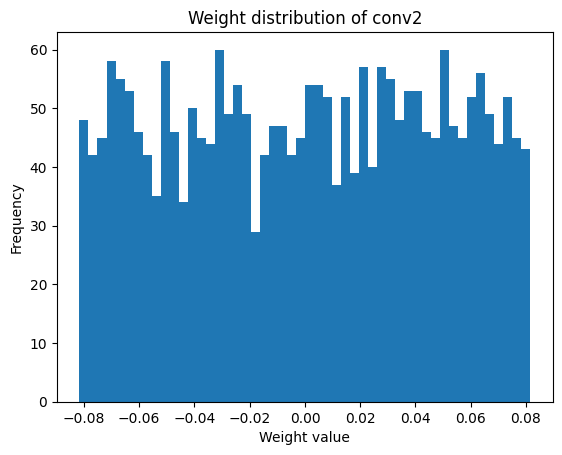

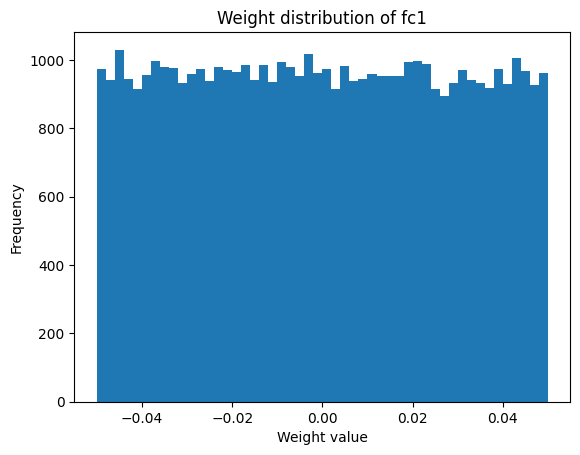

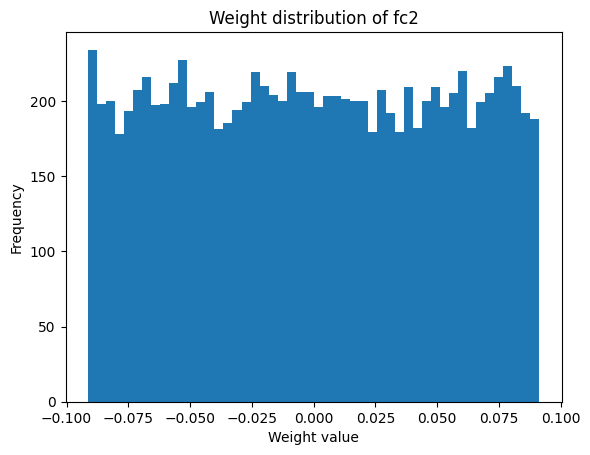

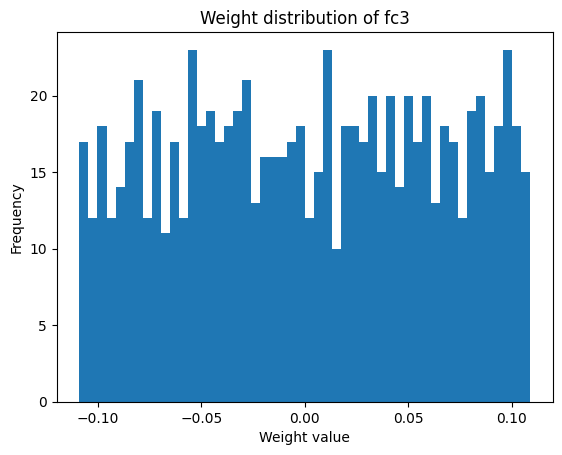

In [61]:
# Visualize Initial Weights
print("Visualizing Initial Weights")
layers = [net.conv1, net.conv2, net.fc1, net.fc2, net.fc3]
layer_names = ['conv1', 'conv2', 'fc1', 'fc2', 'fc3']

for layer, name in zip(layers, layer_names):
    plot_weight_distribution(layer.weight.data, name)
    plt.show()

In [62]:
# Train model
print("\Training and Quantizing Weights")
train_model(net, trainloader, epochs=2)
base_accuracy = test_model(net, testloader)
print(f'Accuracy before quantization: {base_accuracy:.2f}%')

# Create and profile quantized model
quantized_net = QuantizedNet(net).to(device)
quantized_net.profile_activations = True
register_activation_profiling_hooks(quantized_net)

\Training and Quantizing Weights
[1,  2000] loss: 2.173
[1,  4000] loss: 1.883
[1,  6000] loss: 1.687
[1,  8000] loss: 1.622
[1, 10000] loss: 1.562
[1, 12000] loss: 1.503
[2,  2000] loss: 1.430
[2,  4000] loss: 1.397
[2,  6000] loss: 1.373
[2,  8000] loss: 1.374
[2, 10000] loss: 1.356
[2, 12000] loss: 1.331
Finished Training
Accuracy before quantization: 53.44%


In [63]:
# Visualize and Profile Activations
print("\nVisualizing Activations")
test_model(quantized_net, trainloader, max_samples=400)

# Store activations during forward pass
activations = {
    'input_activations': quantized_net.input_activations[-1] if quantized_net.input_activations else None,
}

# Plot activation distributions
for name, activation in activations.items():
    if activation is not None:
        plot_activation_distribution(activation.numpy(), name)
        plt.show()


Visualizing Activations


In [64]:
# Quantize Activations and Test
print("\Testing with Quantized Weights and Activations")
quantized_net.profile_activations = False
quantize_layer_weights(quantized_net)
accuracy = test_model(quantized_net, testloader)
print(f'Accuracy with quantized weights: {accuracy:.2f}%')

\Testing with Quantized Weights and Activations
Accuracy with quantized weights: 54.10%


In [65]:
# Quantize Biases and Final Test
print("\Testing with Quantized Weights, Activations, and Biases")
quantize_model_biases(quantized_net)
final_accuracy = test_model(quantized_net, testloader)
print(f'Accuracy with quantized weights and biases: {final_accuracy:.2f}%')

# Print final comparison
print("\nFinal Results Summary:")
print("-" * 50)
print(f"{'Stage':<25} {'Accuracy (%)'}")
print("-" * 50)
print(f"{'Before Quantization':<25} {base_accuracy:.2f}")
print(f"{'After Weight Quant':<25} {accuracy:.2f}")
print(f"{'After Full Quant':<25} {final_accuracy:.2f}")

\Testing with Quantized Weights, Activations, and Biases
Accuracy with quantized weights and biases: 54.10%

Final Results Summary:
--------------------------------------------------
Stage                     Accuracy (%)
--------------------------------------------------
Before Quantization       53.44
After Weight Quant        54.10
After Full Quant          54.10
